# Telecom churn case study

<b> Buisness problem:</b>
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

Our job is to identify customers who are propbable candidate for churn and for this case study primarily we have to concentrate on high value customers. High value customers are responsible for 80% of revenue. So it's very important to know what are the factors which are affecting the churn.

We will approach this problem with following approach.

Data Preparation
The following data preparation steps are crucial for this problem:
 
<b>1. Derive new features</b>
This is one of the most important parts of data preparation since good features are often the differentiators between good and bad models. Use your business understanding to derive features you think could be important indicators of churn.
 
<b>2. Filter high-value customers</b>
As mentioned above, you need to predict churn only for the high-value customers. Define high-value customers as follows: Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).
 
After filtering the high-value customers, you should get about 29.9k rows.
 
<b>3. Tag churners and remove attributes of the churn phase</b>
Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:
total_ic_mou_9
total_og_mou_9
vol_2g_mb_9
vol_3g_mb_9

After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

<b>Important points:-</b>
<ul>
    <li>We have data for June,july,Aug and Sep month. Out of which June and July are considered as good phase, Aug is considered as Action phase and Sep is considered as Churn phase. So our analysy will be based on 6,7 and 8th month.</li>
    <li>We have to do analysis for only high value customers which will be determined by given logic
</ul>

In [423]:
#importing all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve,f1_score, recall_score, classification_report
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import warnings
warnings.filterwarnings("ignore")

In [424]:
#utility methods for analysis
def model_attr(y_test,y_pred):
    cp = confusion_matrix(y_test,y_pred)
    print(cp)
    
    accuracy = round(accuracy_score(y_test,y_pred),2)
    recall = round(recall_score(y_test,y_pred),2)
    auc = round(roc_auc_score(y_test,y_pred),2)
    f1 = round(f1_score(y_test,y_pred),2)
    
    data = [[accuracy,recall,auc,f1]] 
    df = pd.DataFrame(data, columns = ['Accuracy','Recall','AUC','F1'])
    display(df) 

In [425]:
#let's read the data 
telecom = pd.read_csv('../input/telecom-churn-data/telecom_churn_data.csv')

In [426]:
#shape of the data
telecom.shape

(99999, 226)

So we have around 1L rows and 226 columns

In [427]:
#let's analyse null values percentage per column
null_values = round(((telecom.isnull().sum()[(telecom.isnull().sum()>0)])/telecom.shape[0])*100,2)
null_values

loc_og_t2o_mou           1.02
std_og_t2o_mou           1.02
loc_ic_t2o_mou           1.02
last_date_of_month_7     0.60
last_date_of_month_8     1.10
                        ...  
night_pck_user_9        74.08
fb_user_6               74.85
fb_user_7               74.43
fb_user_8               73.66
fb_user_9               74.08
Length: 166, dtype: float64

In [428]:
#let's analyse those columns which have null values greater than 50%
null_values[null_values > 50]

date_of_last_rech_data_6    74.85
date_of_last_rech_data_7    74.43
date_of_last_rech_data_8    73.66
date_of_last_rech_data_9    74.08
total_rech_data_6           74.85
total_rech_data_7           74.43
total_rech_data_8           73.66
total_rech_data_9           74.08
max_rech_data_6             74.85
max_rech_data_7             74.43
max_rech_data_8             73.66
max_rech_data_9             74.08
count_rech_2g_6             74.85
count_rech_2g_7             74.43
count_rech_2g_8             73.66
count_rech_2g_9             74.08
count_rech_3g_6             74.85
count_rech_3g_7             74.43
count_rech_3g_8             73.66
count_rech_3g_9             74.08
av_rech_amt_data_6          74.85
av_rech_amt_data_7          74.43
av_rech_amt_data_8          73.66
av_rech_amt_data_9          74.08
arpu_3g_6                   74.85
arpu_3g_7                   74.43
arpu_3g_8                   73.66
arpu_3g_9                   74.08
arpu_2g_6                   74.85
arpu_2g_7     

<b><font color='red'>[Observation]:</b> So now we can see there are plenty of number of columns which have null value percentage greater than 50. For being we're not gonna remove/impute null values.

## 1. Deriving new features

If we analyse data dictionary then we can found that we have plenty of columns which have recharge related info (total recharge, total data recharge so from this we will compute total recharge amount paid by customer each month)

In [429]:
#amount related column list
amt_col_list =  telecom.columns[telecom.columns.str.contains('rech_amt|rech_data')]
print(amt_col_list)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'av_rech_amt_data_9'],
      dtype='object')


In [430]:
#let's see descriptive analysis
telecom.loc[:,amt_col_list].describe()

,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,total_rech_amt_9,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,max_rech_amt_9,total_rech_data_6,total_rech_data_7,total_rech_data_8,total_rech_data_9,max_rech_data_6,max_rech_data_7,max_rech_data_8,max_rech_data_9,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,av_rech_amt_data_9
count,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,25153.000000,25571.000000,26339.000000,25922.00000,25153.000000,25571.000000,26339.000000,25922.000000
mean,327.514615,322.962970,324.157122,303.345673,104.637486,104.752398,107.728207,101.943889,2.463802,2.666419,2.651999,2.441170,126.393392,126.729459,125.717301,124.94144,192.600982,200.981292,197.526489,192.734315
std,398.019701,408.114237,416.540455,404.588583,120.614894,124.523970,126.902505,125.375109,2.789128,3.031593,3.074987,2.516339,108.477235,109.765267,109.437851,111.36376,192.646318,196.791224,191.301305,188.400286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,0.500000,0.500000,1.000000
25%,109.000000,100.000000,90.000000,52.000000,30.000000,30.000000,30.000000,28.000000,1.000000,1.000000,1.000000,1.000000,25.000000,25.000000,25.000000,25.00000,82.000000,92.000000,87.000000,69.000000
50%,230.000000,220.000000,225.000000,200.000000,110.000000,110.000000,98.000000,61.000000,1.000000,1.000000,1.000000,2.000000,145.000000,145.000000,145.000000,145.00000,154.000000,154.000000,154.000000,164.000000
75%,437.500000,428.000000,434.500000,415.000000,120.000000,128.000000,144.000000,144.000000,3.000000,3.000000,3.000000,3.000000,177.000000,177.000000,179.000000,179.00000,252.000000,252.000000,252.000000,252.000000
max,35190.000000,40335.000000,45320.000000,37235.000000,4010.000000,4010.000000,4449.000000,3399.000000,61.000000,54.000000,60.000000,84.000000,1555.000000,1555.000000,1555.000000,1555.00000,7546.000000,4365.000000,4076.000000,4061.000000


In [431]:
#let's see whether there are any null values present in these columns
telecom[amt_col_list].isnull().sum()

total_rech_amt_6                0
total_rech_amt_7                0
total_rech_amt_8                0
total_rech_amt_9                0
max_rech_amt_6                  0
max_rech_amt_7                  0
max_rech_amt_8                  0
max_rech_amt_9                  0
date_of_last_rech_data_6    74846
date_of_last_rech_data_7    74428
date_of_last_rech_data_8    73660
date_of_last_rech_data_9    74077
total_rech_data_6           74846
total_rech_data_7           74428
total_rech_data_8           73660
total_rech_data_9           74077
max_rech_data_6             74846
max_rech_data_7             74428
max_rech_data_8             73660
max_rech_data_9             74077
av_rech_amt_data_6          74846
av_rech_amt_data_7          74428
av_rech_amt_data_8          73660
av_rech_amt_data_9          74077
dtype: int64

<b><font color='red'>[Observation]:</b> There are columns which have null values

In [432]:
#now we will assume wherever data is not present means recharge amount for data or recharge is 0. Replace nan with 0.
#for our analysis we're considering only 6,7 and 8th month
#we will date related column null values as it is
telecom['total_rech_data_6'] = telecom['total_rech_data_6'].replace(np.NaN,0.0)
telecom['total_rech_data_7'] = telecom['total_rech_data_7'].replace(np.NaN,0.0)
telecom['total_rech_data_8'] = telecom['total_rech_data_8'].replace(np.NaN,0.0)
telecom['av_rech_amt_data_6'] = telecom['av_rech_amt_data_6'].replace(np.NaN,0.0)
telecom['av_rech_amt_data_7'] = telecom['av_rech_amt_data_7'].replace(np.NaN,0.0)
telecom['av_rech_amt_data_8'] = telecom['av_rech_amt_data_8'].replace(np.NaN,0.0)
telecom['total_rech_amt_data_6'] = telecom.av_rech_amt_data_6 * telecom.total_rech_data_6
telecom['total_rech_amt_data_7'] = telecom.av_rech_amt_data_7 * telecom.total_rech_data_7
telecom['total_rech_amt_data_8'] = telecom.av_rech_amt_data_8 * telecom.total_rech_data_8

In [433]:
#Derived variable 1 - average recharge done for each month (including data and normal recharge)
#we'll consider only good phase as this will be require to determine high value customers
telecom['avg_rech_per_month_good_phase'] = (telecom.total_rech_amt_6 + telecom.total_rech_amt_data_6 \
                                               + telecom.total_rech_amt_7+ telecom.total_rech_amt_data_7)/2

In [434]:
#now we have to determine high value customers

In [435]:
#Defination - Those who have recharged with an amount more than or equal to X, where X is the 70th percentile of the average recharge amount in the first two months (the good phase).

In [436]:
#as specified after filtering there needs to be 29.9k rows.
high_condn_amount = telecom.avg_rech_per_month_good_phase.quantile(0.7)
telecom = telecom[telecom.avg_rech_per_month_good_phase > high_condn_amount]
telecom.shape

(29953, 230)

<b>Logic to identify churned customer </b><br>
Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. The attributes you need to use to tag churners are:<br>
total_ic_mou_9<br>
total_og_mou_9<br>
vol_2g_mb_9<br>
vol_3g_mb_9<br>

In [437]:
#now we have to identify customers who have churned. For that we'll use logic given by buisness
churn_col_list = ['total_ic_mou_9', 'total_og_mou_9', 'vol_2g_mb_9','vol_3g_mb_9']

In [438]:
#let's see whether these columns have any null values
telecom[churn_col_list].isnull().sum()

total_ic_mou_9    0
total_og_mou_9    0
vol_2g_mb_9       0
vol_3g_mb_9       0
dtype: int64

In [439]:
# Initially set all the va9lues as 0
telecom.loc[:,'churn']= 0

In [440]:
#logic to identify churned customer
is_churned = (telecom.total_ic_mou_9 == 0) & \
             (telecom.total_og_mou_9 == 0) & \
             (telecom.vol_2g_mb_9 ==0) & \
             (telecom.vol_3g_mb_9 ==0)

In [441]:
telecom.loc[is_churned,'churn']=1

In [442]:
print("Percentage of high value customers are churned",round(100*telecom.churn.sum()/len(telecom),2))

Percentage of high value customers are churned 8.12


In [443]:
#let's remove all other data for 9th month
churn_month_columns =  telecom.columns[telecom.columns.str.contains('_9')]

In [444]:
# drop all columns corresponding to the churn phase
telecom.drop(churn_month_columns,axis=1,inplace=True)

This is the required data (data of high value customers). Now we'll remove unwanted columns.

# Removing unwanted columns

Let's see which columns doesn't have variation in data (have  only 1 or 2 types of values)

In [445]:
#utility method to look for value count
def value_count(telecom_meta):
    telecom_meta = pd.DataFrame([])
    telecom_meta['columns'] = telecom.columns
    telecom_meta['dtypes'] = telecom.dtypes.values
    i = 0
    for col in telecom.columns:
        telecom_meta.loc[i,'value_count'] = len(telecom[col].value_counts().index.values)
        i+=1
    return telecom_meta

In [446]:
telecom_meta = value_count(telecom)

In [447]:
telecom_meta[telecom_meta.value_count == 1]

,columns,dtypes,value_count
1,circle_id,int64,1.0
2,loc_og_t2o_mou,float64,1.0
3,std_og_t2o_mou,float64,1.0
4,loc_ic_t2o_mou,float64,1.0
5,last_date_of_month_6,object,1.0
6,last_date_of_month_7,object,1.0
7,last_date_of_month_8,object,1.0
47,std_og_t2c_mou_6,float64,1.0
48,std_og_t2c_mou_7,float64,1.0
49,std_og_t2c_mou_8,float64,1.0


<b><font color='red'>[Observation]:</b> We can see that there are multiple colums which have only 1 type of value hence we will remove this columns. Besides we will remove mobile_number column as well as it has all unique values.

In [448]:
telecom.drop(telecom_meta[telecom_meta.value_count == 1]['columns'].values,axis=1,inplace=True)
telecom.drop(columns='mobile_number',axis=1,inplace=True)
#we'll remove date related columns as well as they are not necessary for our analysis
telecom.drop(telecom.columns[telecom.columns.str.contains('date')],axis=1,inplace=True)

In [449]:
telecom

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,avg_rech_per_month_good_phase,churn
0,197.385,214.816,213.803,NaN,NaN,0.00,NaN,NaN,0.00,NaN,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,559.0,1
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,802,57.74,19.38,18.74,0.00,0.0,0.0,0.0,1185.0,1
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,315,21.03,910.65,122.16,0.00,0.0,354.0,207.0,696.0,0
21,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,0.00,...,720,0.00,0.00,0.00,0.00,0.0,0.0,0.0,640.0,0
23,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,0.00,...,604,40.45,51.86,0.00,0.00,0.0,712.0,540.0,583.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99981,384.316,255.405,393.474,78.68,29.04,103.24,56.13,28.09,61.44,0.00,...,473,1100.43,619.59,668.05,0.33,252.0,252.0,252.0,564.0,0
99984,328.594,202.966,118.707,423.99,181.83,5.71,39.51,39.81,18.26,0.00,...,820,0.00,0.00,0.00,0.00,154.0,484.0,585.0,618.5,0
99986,644.973,455.228,564.334,806.73,549.36,775.41,784.76,617.13,595.44,0.00,...,2696,497.45,598.67,604.08,0.00,17.0,14.0,25.0,864.0,0
99988,312.558,512.932,402.080,199.89,174.46,2.46,175.88,277.01,248.33,0.00,...,328,104.73,0.00,0.00,0.00,0.0,154.0,154.0,544.0,0


Now we have have dataframe which consits of required rows and columns. Let's dig deep to understand the data

# EDA

In [450]:
#Let's deal with null values first
#we'll deal with null values on the basis of their property
def null_value(df,fil):
    null_values = round((df.isnull().sum()[df.isnull().sum()>0]/len(df))*100,2)
    if fil != 'All':
        return (null_values[null_values.index.str.contains(fil,regex=True)])
    else:
        return (null_values)

In [451]:
#first - minutes of usage related null values
#null_values[null_values.index.str.contains('mou',regex=True)]
null_value(telecom,'mou')

onnet_mou_6     1.81
onnet_mou_7     1.79
onnet_mou_8     3.91
offnet_mou_6    1.81
offnet_mou_7    1.79
                ... 
spl_ic_mou_7    1.79
spl_ic_mou_8    3.91
isd_ic_mou_6    1.81
isd_ic_mou_7    1.79
isd_ic_mou_8    3.91
Length: 75, dtype: float64

In [452]:
#we are assuming that whenever minuts of usage is nan then user haven't called. Hence replace Nan with 0
telecom[null_value(telecom,'mou').index] = telecom[null_value(telecom,'mou').index].replace(np.NaN,0.0)

In [453]:
null_value(telecom,'mou')

Series([], dtype: float64)

In [454]:
null_value(telecom,'All')

og_others_6          1.81
og_others_7          1.79
og_others_8          3.91
ic_others_6          1.81
ic_others_7          1.79
ic_others_8          3.91
max_rech_data_6     44.11
max_rech_data_7     43.12
max_rech_data_8     46.80
count_rech_2g_6     44.11
count_rech_2g_7     43.12
count_rech_2g_8     46.80
count_rech_3g_6     44.11
count_rech_3g_7     43.12
count_rech_3g_8     46.80
arpu_3g_6           44.11
arpu_3g_7           43.12
arpu_3g_8           46.80
arpu_2g_6           44.11
arpu_2g_7           43.12
arpu_2g_8           46.80
night_pck_user_6    44.11
night_pck_user_7    43.12
night_pck_user_8    46.80
fb_user_6           44.11
fb_user_7           43.12
fb_user_8           46.80
dtype: float64

In [455]:
telecom[['og_others_6','og_others_7','og_others_8','ic_others_6','ic_others_7','ic_others_8']].describe()

,og_others_6,og_others_7,og_others_8,ic_others_6,ic_others_7,ic_others_8
count,29411.000000,29417.000000,28781.000000,29411.000000,29417.000000,28781.000000
mean,0.673738,0.043743,0.060043,1.176512,1.529164,1.276098
std,4.147630,2.703227,3.384640,14.124567,16.153401,13.048836
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.060000,0.000000,0.060000
max,609.810000,370.130000,394.930000,1344.140000,1495.940000,1209.860000


In [456]:
#for 'og_others_6','og_others_7','og_others_8','ic_others_6','ic_others_7','ic_others_8' we'll replace Nan with 0. From data we can 
#conclude that these columns doesn't have enough info to help our analysis but we won't delete these columns, we will leave it to PCA
telecom[['og_others_6','og_others_7','og_others_8','ic_others_6','ic_others_7','ic_others_8']]=telecom[['og_others_6','og_others_7','og_others_8','ic_others_6','ic_others_7','ic_others_8']].replace(np.NaN,0.0)

In [457]:
null_value(telecom,'All')

max_rech_data_6     44.11
max_rech_data_7     43.12
max_rech_data_8     46.80
count_rech_2g_6     44.11
count_rech_2g_7     43.12
count_rech_2g_8     46.80
count_rech_3g_6     44.11
count_rech_3g_7     43.12
count_rech_3g_8     46.80
arpu_3g_6           44.11
arpu_3g_7           43.12
arpu_3g_8           46.80
arpu_2g_6           44.11
arpu_2g_7           43.12
arpu_2g_8           46.80
night_pck_user_6    44.11
night_pck_user_7    43.12
night_pck_user_8    46.80
fb_user_6           44.11
fb_user_7           43.12
fb_user_8           46.80
dtype: float64

In [458]:
#we will delete all columns which have null values greater than 40%
telecom.drop(null_value(telecom,'All').index.values,axis=1,inplace=True)

In [459]:
#we can see no null values now
null_value(telecom,'All')

Series([], dtype: float64)

In [460]:
print(telecom.shape)
print(telecom['churn'][telecom.churn == 1].count())

(29953, 136)
2433


In [461]:
telecom[telecom.churn == 1]

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,avg_rech_per_month_good_phase,churn
0,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,968,30.40,0.00,101.20,3.58,252.0,252.0,252.0,559.0,1
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,802,57.74,19.38,18.74,0.00,0.0,0.0,0.0,1185.0,1
67,218.818,386.515,386.502,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,1158,126.21,745.73,1010.15,0.00,252.0,455.0,0.0,707.0,1
86,319.700,56.080,1.030,141.76,11.23,0.00,182.76,32.79,1.71,0.00,...,465,0.00,394.62,1526.51,0.00,616.0,0.0,0.0,528.0,1
111,596.301,146.073,0.000,55.19,3.26,0.00,45.51,12.34,0.00,0.00,...,332,0.00,0.00,0.00,0.00,406.0,0.0,0.0,644.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99827,1053.035,20.060,0.000,1263.94,0.06,0.00,151.26,0.00,0.00,385.51,...,509,0.00,0.00,0.00,0.00,0.0,0.0,0.0,673.0,1
99851,446.574,0.000,0.000,11.29,0.00,0.00,280.88,0.00,0.00,0.00,...,709,0.00,0.00,287.90,0.00,2544.0,0.0,0.0,1531.0,1
99868,594.210,591.700,506.715,230.93,73.76,55.93,194.11,191.04,59.06,0.00,...,730,0.00,0.00,0.00,0.00,4147.0,5850.0,1614.0,5662.5,1
99885,456.151,486.175,526.636,741.94,931.84,966.33,63.53,27.08,50.06,0.00,...,529,0.00,0.00,0.00,0.00,0.0,0.0,0.0,532.0,1


In [462]:
#utility method to remove outliers
def rm_outl(dtf, numl_list):
    for j in numl_list:
        Q1 = dtf[j].quantile(0.05)
        Q3 = dtf[j].quantile(0.95)
        IQR = Q3 - Q1      
        dtf = dtf[(dtf[j] >= Q1-2.5*IQR) & (dtf[j] <= Q3+2.5*IQR)]
    return dtf

In [463]:
#utility method to plot charts
def box_plots(col):
    plt.figure(figsize=(20,16))
    df = rm_outl(telecom,[col+'_6',col+'_7',col+'_8'])
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=col+"_6",x="churn",hue="churn")
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=col+"_7",x="churn",hue="churn")
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=col+"_8",x="churn",hue="churn")
    plt.show()

## Analysis

In [464]:
#Let's do univariate analysis of recharge related column first
rech_col = telecom.columns[telecom.columns.str.contains('rech_amt')].values
print(rech_col)

['total_rech_amt_6' 'total_rech_amt_7' 'total_rech_amt_8' 'max_rech_amt_6'
 'max_rech_amt_7' 'max_rech_amt_8' 'av_rech_amt_data_6'
 'av_rech_amt_data_7' 'av_rech_amt_data_8' 'total_rech_amt_data_6'
 'total_rech_amt_data_7' 'total_rech_amt_data_8']


In [465]:
#first let's remove outliers
#telecom = rm_outl(telecom,rech_col)
#we've lost around 500 rows
print(telecom.shape)
print(telecom['churn'][telecom.churn == 1].count())

(29953, 136)
2433


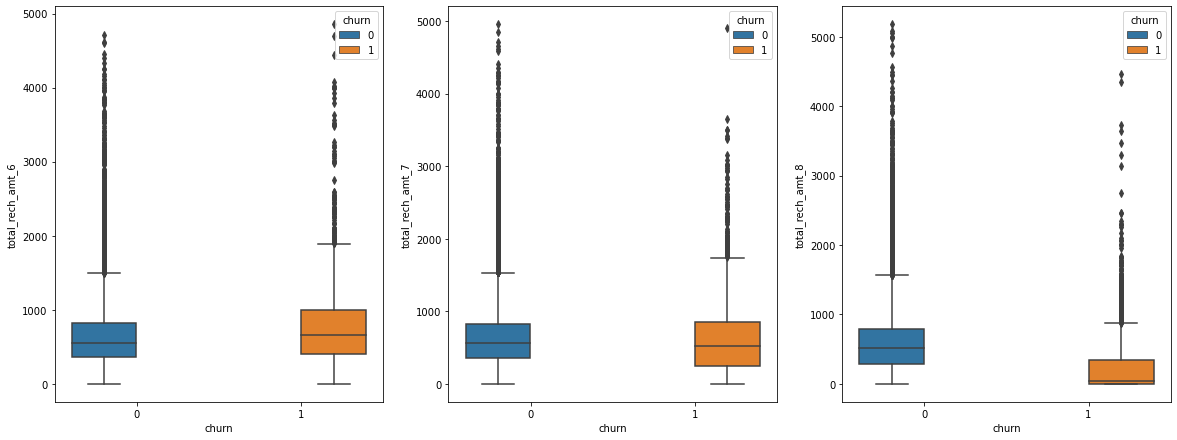

In [466]:
box_plots('total_rech_amt')

<b><font color='red'>[Observation]:</b> We can see that in action phase total recharge amount is reduced for churn customers.

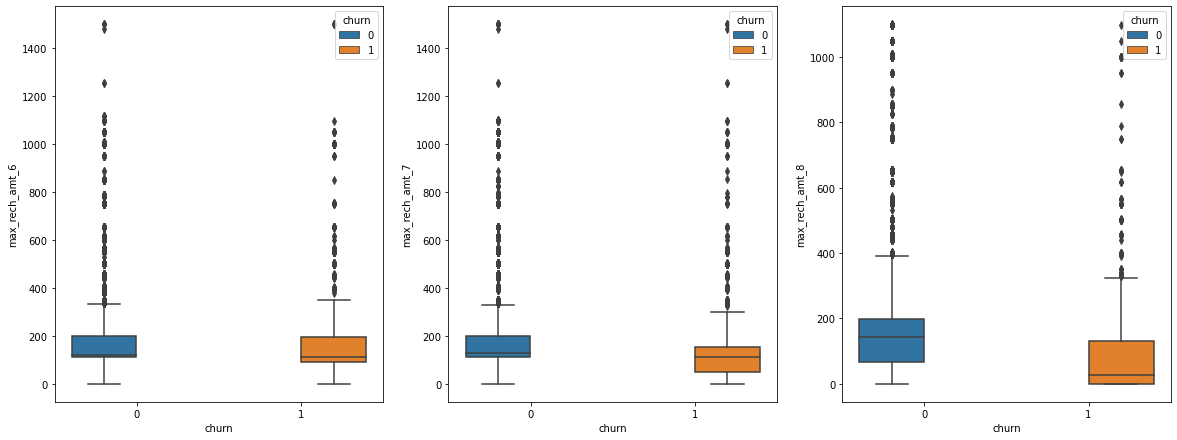

In [467]:
box_plots('max_rech_amt')

<b><font color='red'>[Observation]:</b> We can see that in action phase total max recharge amount is reduced for churn customers.

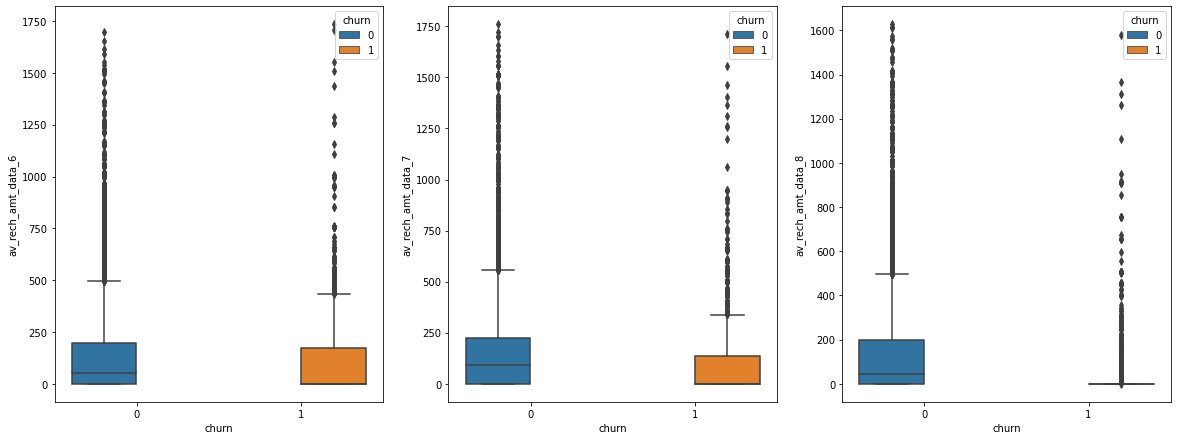

In [468]:
box_plots('av_rech_amt_data')

<b><font color='red'>[Observation]:</b> We can see that in action phase average recharge amount is reduced for churn customers.

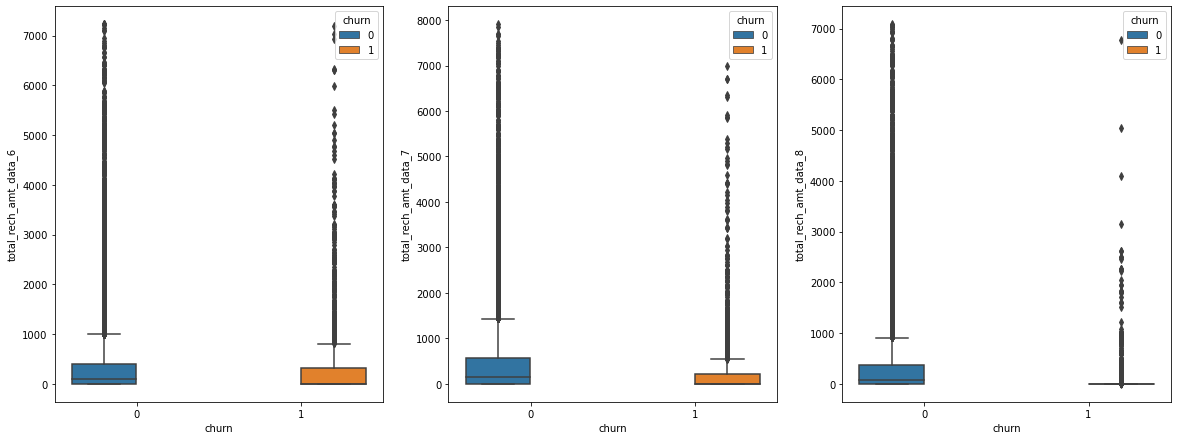

In [469]:
box_plots('total_rech_amt_data')

<b><font color='red'>[Observation]:</b> We can see that in action phase total rech amount data is reduced for churn customers.

In [470]:
#we've column which represents age on network which has unit as days, we'll convert that into months by dividing days/30
telecom['Age_on_network'] = telecom.aon/30
telecom.drop(columns='aon',inplace=True)

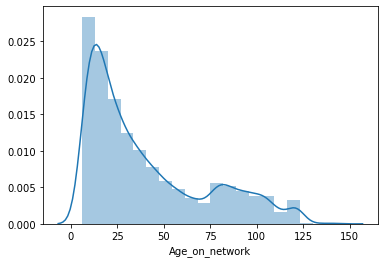

In [471]:
sns.distplot(telecom['Age_on_network'],bins=20)

<b><font color='red'>[Observation]:</b> Distribution is right skewed. Most of the customers are 1-50 months old.

In [472]:
#Let's find out range so that we can determine age of the network which exerienced greater churn rate
mn_range = [0, 6, 12, 24, 60, 61]
mn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
telecom['Age_range'] = pd.cut(telecom['Age_on_network'], mn_range, labels=mn_label)

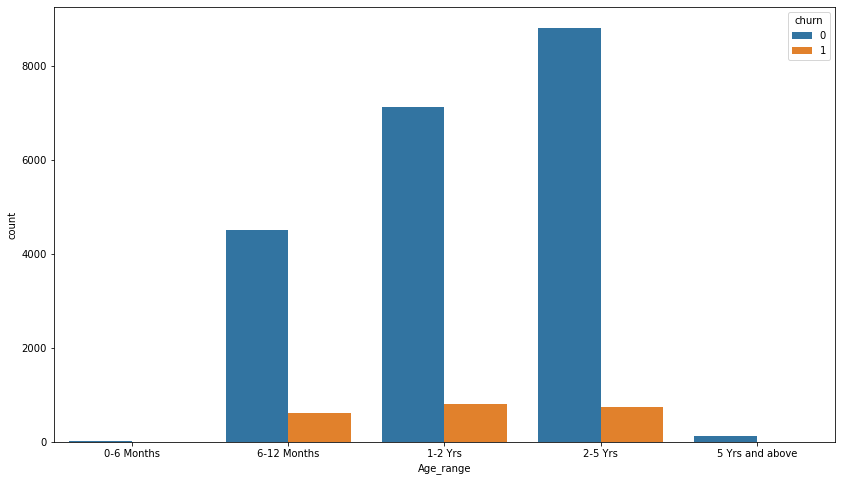

In [473]:
plt.figure(figsize=(14,8))
sns.countplot(x = 'Age_range', hue = 'churn',data = telecom)

<b><font color='red'>[Observation]:</b> Count plot suggesting equal distribution of churn rate. Let's see percentage wise churn rate for each category.

In [474]:
index = telecom.groupby('Age_range')['churn'].sum().index.values
churn = telecom.groupby('Age_range')['churn'].sum().values
total = telecom.groupby('Age_range')['Age_range'].count().values


In [475]:
age_data = pd.DataFrame(data=[index,churn,total],columns=['range','churn','total'])
display(age_data)

,range,churn,total
0,0-6 Months,3,15
1,6-12 Months,618,5133
2,1-2 Yrs,801,7940
3,2-5 Yrs,744,9562
4,5 Yrs and above,6,139


In [476]:
age_data['perc'] = round((age_data.churn/age_data.total)*100)

In [477]:
age_data

,range,churn,total,perc
0,0-6 Months,3,15,20.0
1,6-12 Months,618,5133,12.0
2,1-2 Yrs,801,7940,10.0
3,2-5 Yrs,744,9562,8.0
4,5 Yrs and above,6,139,4.0


<b><font color='red'>[Observation]:</b> We have to ignore first range as data is not sufficient to comment. So churn rate is maximum for the customers who have spent 6-12 months on the network.

In [478]:
#we'll drop Age_on_network
telecom.drop(columns='Age_on_network',inplace=True)

In [479]:
telecom[['arpu_6','arpu_7','arpu_8']].describe()

,arpu_6,arpu_7,arpu_8
count,29953.000000,29953.000000,29953.000000
mean,558.820058,561.160547,508.890301
std,460.868223,480.028497,502.136278
min,-2258.709000,-2014.045000,-945.808000
25%,310.142000,310.071000,231.615000
50%,482.354000,481.496000,427.604000
75%,700.240000,698.829000,661.753000
max,27731.088000,35145.834000,33543.624000


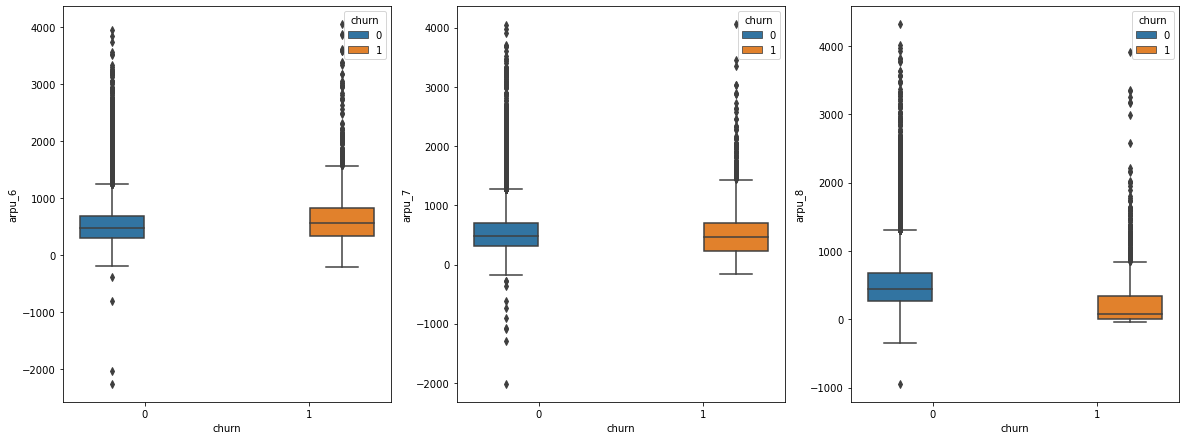

In [480]:
#let's see average revenue per customer for 6,7 and 8th phase
box_plots('arpu')

<b><font color='red'>[Observation]:</b> Average revenue per customer is less for 8th month as compare to 6 and 7th month

In [481]:
telecom[['max_rech_amt_6','max_rech_amt_7','max_rech_amt_8']].describe()

,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8
count,29953.000000,29953.000000,29953.000000
mean,169.348145,172.281474,160.224351
std,175.421794,181.504312,173.298179
min,0.000000,0.000000,0.000000
25%,110.000000,110.000000,50.000000
50%,120.000000,128.000000,130.000000
75%,200.000000,200.000000,198.000000
max,4010.000000,4010.000000,4449.000000


<b><font color='red'>[Observation]:</b> Maximum recharge amount is not giving significant information 

## Data preprocessing

In [482]:
#let's do dummy encoding for categorical variable
temp = pd.get_dummies(telecom.Age_range,drop_first=True)
telecom.drop(columns='Age_range',axis=1,inplace=True)
telecom = pd.concat([telecom,temp],axis=1)

In [483]:
#train test split
from sklearn.model_selection import train_test_split,cross_val_score

In [484]:
X = telecom.drop(['churn'],axis=1)
X.head()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,...,jun_vbc_3g,sep_vbc_3g,total_rech_amt_data_6,total_rech_amt_data_7,total_rech_amt_data_8,avg_rech_per_month_good_phase,6-12 Months,1-2 Yrs,2-5 Yrs,5 Yrs and above
0,197.385,214.816,213.803,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,101.20,3.58,252.0,252.0,252.0,559.0,0,0,1,0
7,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,...,18.74,0.00,0.0,0.0,0.0,1185.0,0,0,1,0
8,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,...,122.16,0.00,0.0,354.0,207.0,696.0,1,0,0,0
21,514.453,597.753,637.760,102.41,132.11,85.14,757.93,896.68,983.39,0.00,...,0.00,0.00,0.0,0.0,0.0,640.0,0,1,0,0
23,74.350,193.897,366.966,48.96,50.66,33.58,85.41,89.36,205.89,0.00,...,0.00,0.00,0.0,712.0,540.0,583.0,0,1,0,0


In [485]:
y = telecom['churn']

In [486]:
X_train, X_test, y_train, y_test = train_test_split(X, y , train_size = 0.7, random_state = 43)

In [487]:
from sklearn.preprocessing import StandardScaler

In [488]:
scalar = StandardScaler()


In [489]:
num_colms = ['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_6',
       'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'loc_og_mou_6',
       'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6',
       'std_og_mou_7', 'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7',
       'isd_og_mou_8', 'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8',
       'og_others_6', 'og_others_7', 'og_others_8', 'total_og_mou_6',
       'total_og_mou_7', 'total_og_mou_8', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mou_7', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_6',
       'loc_ic_t2m_mou_7', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_6',
       'loc_ic_t2f_mou_7', 'loc_ic_t2f_mou_8', 'loc_ic_mou_6',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2t_mou_6',
       'std_ic_t2t_mou_7', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_6',
       'std_ic_t2m_mou_7', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_mou_6',
       'std_ic_mou_7', 'std_ic_mou_8', 'total_ic_mou_6', 'total_ic_mou_7',
       'total_ic_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8',
       'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6',
       'ic_others_7', 'ic_others_8', 'total_rech_num_6',
       'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6',
       'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'last_day_rch_amt_6',
       'last_day_rch_amt_7', 'last_day_rch_amt_8', 'total_rech_data_6',
       'total_rech_data_7', 'total_rech_data_8', 'av_rech_amt_data_6',
       'av_rech_amt_data_7', 'av_rech_amt_data_8', 'vol_2g_mb_6',
       'vol_2g_mb_7', 'vol_2g_mb_8', 'vol_3g_mb_6', 'vol_3g_mb_7',
       'vol_3g_mb_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8',
       'sachet_2g_6', 'sachet_2g_7', 'sachet_2g_8', 'monthly_3g_6',
       'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'sep_vbc_3g', 'total_rech_amt_data_6', 'total_rech_amt_data_7',
       'total_rech_amt_data_8', 'avg_rech_per_month_good_phase']
#X_train[num_colms] = scalar.fit(X_train[num_colms]).transform(X_train[num_colms])
X_scaler = StandardScaler().fit(X_train[num_colms])
X_train[num_colms] = X_scaler.transform(X_train[num_colms])
X_test[num_colms] = X_scaler.transform(X_test[num_colms])

In [490]:
smote = SMOTE(sampling_strategy='auto', random_state=43)
X_train_smote,y_train_smote = smote.fit_sample(X_train,y_train)
print("Shape of train datatset after SMOTE : "+str(X_train_smote.shape))

X_train = pd.DataFrame(X_train_smote, columns=X_train.columns)
y_train = pd.DataFrame(y_train_smote)


Shape of train datatset after SMOTE : (38478, 138)


In [491]:
#Let's see distribution of churn rate in train and test
print("Train churn rate - ",round((y_train[y_train==1].sum()/len(y_train))*100,2))
print("Test churn rate - ",round((y_test[y_test==1].sum()/len(y_test))*100,2))

Train churn rate -  churn    50.0
dtype: float64
Test churn rate -  7.85


In [492]:
#so distribution is symmetrical

In [493]:
plt.figure(figsize=(20,8))
#sns.heatmap(X_train.corr())

<Figure size 1440x576 with 0 Axes>

<Figure size 1440x576 with 0 Axes>

<b><font color='red'>[Observation]:</b> We are not going to remove columns based on thier multicollinearity, we'll model decide which colmns are important using RFE or PCA.

## Modeling

Before proceeding to modeling few points to note down.
   <ul>
    <li>This is the case of class imbalance which we have sorted out using SMOTE method.</li>
    <li>We will be creating two type of models.</li>
    <ul>
        <li>Interpretable model - Will give us idea about which features are important for classification.</li>
        <li>Deployable model - Will have high recall (as we've to increase our chances of predicting churn customer).
    </ul>
    <li>We will use RFE for interpretable model to identify important features and PCA to reduce dimentionality for deployable models.
   <ul>

### 1) Plain Logistic regression
Let's begain with plain logistic regression

In [494]:
import statsmodels.api as sm

In [495]:
#utility method for logistic regression
def log_reg(df):
    logml = sm.GLM(y_train,(sm.add_constant(df)),family=sm.families.Binomial())
    return logml.fit()

In [496]:
op = log_reg(X_train)
op.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38478
Model:                            GLM   Df Residuals:                    38343
Model Family:                Binomial   Df Model:                          134
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 23 Nov 2020   Deviance:                          nan
Time:                        09:35:06   Pearson chi2:                 3.44e+19
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                         -1.294e+14   6.08e+05  -2.13e+08      0.000   -1.29e+14   -1.29e+14
arpu_6                          3.58e+13   1.44e+06   2.49e+07      0.000    3.58e+13    3.58e+13
arpu_7                         2.774e+13   1.72e+06   1.61e+07      0.000    2.77e+13    2.77e+13
arpu_8                         2.163e+14    1.9e+06   1.14e+08      0.000    2.16e+14    2.16e+14
onnet_mou_6                    6.033e+13   1.42e+07   4.25e+06      0.000    6.03e+13    6.03e+13
onnet_mou_7                   -8.759e+13   2.35e+07  -3.73e+06      0.000   -8.76e+13   -8.76e+13
onnet_mou_8                   -1.897e+14   2.68e+07  -7.08e+06      0.000    -1.9e+14    -1.9e+14
offnet_mou_6                   5.658e+14   1.41e+07   4.01e+07      0.000    5.66e+14    5.66e+14
offnet_mou_7                   4.869e+13   2.42e+07   2.01e+06      0.000    4.87e+13    4.87e+13
offnet_mou_8                  -9.975e+14   2.82e+07  -3.54e+07      0.000   -9.97e+14   -9.97e+14
roam_ic_mou_6                  1.196e+13   4.46e+05   2.68e+07      0.000     1.2e+13     1.2e+13
roam_ic_mou_7                  3.116e+12   5.03e+05    6.2e+06      0.000    3.12e+12    3.12e+12
roam_ic_mou_8                 -1.924e+13   4.94e+05   -3.9e+07      0.000   -1.92e+13   -1.92e+13
roam_og_mou_6                 -1.282e+14   3.29e+06   -3.9e+07      0.000   -1.28e+14   -1.28e+14
roam_og_mou_7                 -2.955e+13   4.66e+06  -6.34e+06      0.000   -2.96e+13   -2.96e+13
roam_og_mou_8                  1.695e+14    6.2e+06   2.73e+07      0.000     1.7e+14     1.7e+14
loc_og_t2t_mou_6               1.819e+18   1.59e+10   1.15e+08      0.000    1.82e+18    1.82e+18
loc_og_t2t_mou_7               6.226e+17   1.61e+10   3.86e+07      0.000    6.23e+17    6.23e+17
loc_og_t2t_mou_8               1.565e+18   1.62e+10   9.68e+07      0.000    1.57e+18    1.57e+18
loc_og_t2m_mou_6               1.935e+18   1.69e+10   1.15e+08      0.000    1.94e+18    1.94e+18
loc_og_t2m_mou_7               6.274e+17   1.63e+10   3.86e+07      0.000    6.27e+17    6.27e+17
loc_og_t2m_mou_8               1.661e+18   1.72e+10   9.68e+07      0.000    1.66e+18    1.66e+18
loc_og_t2f_mou_6               1.776e+17   1.55e+09   1.15e+08      0.000    1.78e+17    1.78e+17
loc_og_t2f_mou_7               6.046e+16   1.57e+09   3.86e+07      0.000    6.05e+16    6.05e+16
loc_og_t2f_mou_8               1.422e+17   1.47e+09   9.68e+07      0.000    1.42e+17    1.42e+17
loc_og_t2c_mou_6              -5.925e+13   4.95e+05   -1.2e+08      0.000   -5.93e+13   -5.93e+13
loc_og_t2c_mou_7               1.631e+13   5.94e+05   2.74e+07      0.000    1.63e+13    1.63e+13
loc_og_t2c_mou_8               5.108e+13   6.02e+05   8.48e+07      0.000    5.11e+13    5.11e+13
loc_og_mou_6                  -2.315e+18   3.

<b><font color='red'>[Observation]:</b> We can see that there are too many features which are insignificant but we won't go and dump them manually rather use RFE to find the importnat features.

### 2) Logistic regression using RFE - Interpretable model
We will use 20 important features then will decide which one to select base on p value and VIF.

In [497]:
logreg = LogisticRegression()


rfe = RFE(logreg, 20)            
rfe = rfe.fit(X_train, y_train)

In [498]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_6', False, 27),
 ('arpu_7', False, 2),
 ('arpu_8', False, 44),
 ('onnet_mou_6', False, 9),
 ('onnet_mou_7', True, 1),
 ('onnet_mou_8', True, 1),
 ('offnet_mou_6', False, 12),
 ('offnet_mou_7', False, 80),
 ('offnet_mou_8', False, 5),
 ('roam_ic_mou_6', False, 69),
 ('roam_ic_mou_7', False, 90),
 ('roam_ic_mou_8', False, 70),
 ('roam_og_mou_6', False, 68),
 ('roam_og_mou_7', False, 43),
 ('roam_og_mou_8', False, 67),
 ('loc_og_t2t_mou_6', False, 11),
 ('loc_og_t2t_mou_7', False, 57),
 ('loc_og_t2t_mou_8', True, 1),
 ('loc_og_t2m_mou_6', False, 13),
 ('loc_og_t2m_mou_7', False, 56),
 ('loc_og_t2m_mou_8', False, 103),
 ('loc_og_t2f_mou_6', False, 45),
 ('loc_og_t2f_mou_7', False, 50),
 ('loc_og_t2f_mou_8', False, 115),
 ('loc_og_t2c_mou_6', False, 40),
 ('loc_og_t2c_mou_7', False, 91),
 ('loc_og_t2c_mou_8', False, 41),
 ('loc_og_mou_6', False, 99),
 ('loc_og_mou_7', False, 42),
 ('loc_og_mou_8', False, 29),
 ('std_og_t2t_mou_6', False, 10),
 ('std_og_t2t_mou_7', True, 1),
 ('std_o

In [499]:
#selecting column selected by RFE
col = X_train.columns[rfe.support_]

In [500]:
#now we will use only those columns which are selected by RFE and will create model and then will tune manually
op = log_reg(X_train[col])
op.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38478
Model:                            GLM   Df Residuals:                    38457
Model Family:                Binomial   Df Model:                           20
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -13731.
Date:                Mon, 23 Nov 2020   Deviance:                       27461.
Time:                        09:36:23   Pearson chi2:                 1.95e+05
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.3386      0.057    -23.514      0.000      -1.450      -1.227
onnet_mou_7            1.2125      0.082     14.855      0.000       1.053       1.373
onnet_mou_8            0.5859      0.072      8.090      0.000       0.444       0.728
loc_og_t2t_mou_8      -0.7565      0.074    -10.186      0.000      -0.902      -0.611
std_og_t2t_mou_7      -0.7936      0.073    -10.804      0.000      -0.938      -0.650
std_og_t2m_mou_8       0.9189      0.067     13.652      0.000       0.787       1.051
total_og_mou_8        -1.8572      0.108    -17.272      0.000      -2.068      -1.646
loc_ic_t2m_mou_7       0.9074      0.048     18.921      0.000       0.813       1.001
loc_ic_t2m_mou_8      -1.7543      0.137    -12.795      0.000      -2.023      -1.486
loc_ic_t2f_mou_8      -0.5108      0.063     -8.061      0.000      -0.635      -0.387
loc_ic_mou_8          -0.8679      0.146     -5.954      0.000      -1.154      -0.582
total_ic_mou_8        -0.4455      0.067     -6.606      0.000      -0.578      -0.313
last_day_rch_amt_8    -0.5737      0.025    -22.622      0.000      -0.623      -0.524
av_rech_amt_data_8    -0.5643      0.027    -20.938      0.000      -0.617      -0.511
monthly_2g_8          -0.6393      0.031    -20.738      0.000      -0.700      -0.579
sachet_2g_8           -0.7713      0.032    -23.923      0.000      -0.834      -0.708
sep_vbc_3g            -3.5271      0.327    -10.775      0.000      -4.169      -2.885
6-12 Months           -1.9109      0.047    -40.398      0.000      -2.004      -1.818
1-2 Yrs               -1.9057      0.042    -45.339      0.000      -1.988      -1.823
2-5 Yrs               -2.1054      0.043    -49.296      0.000      -2.189      -2.022
5 Yrs and above       -3.8743      0.505     -7.673      0.000      -4.864      -2.885
======================================================================================
"""

<b><font color='red'>[Observation]:</b> All selected variables are significant, But we've not checked for multicolinearity we'll do it using VIF.
   

In [501]:
col = list(col)

In [502]:
#let's see if there any multicolinearity exists
from statsmodels.stats.outliers_influence import variance_inflation_factor
def VIF(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    display(vif)
VIF(X_train[col])
    

,Features,VIF
5,total_og_mou_8,12.72
0,onnet_mou_7,12.35
3,std_og_t2t_mou_7,11.61
9,loc_ic_mou_8,10.23
1,onnet_mou_8,6.99
7,loc_ic_t2m_mou_8,6.34
10,total_ic_mou_8,6.21
4,std_og_t2m_mou_8,5.20
2,loc_og_t2t_mou_8,3.16
6,loc_ic_t2m_mou_7,2.44


<b><font color='red'>[Observation]:</b> total_og_mou_8 has higher VIF which suggest multi collinrarity we will remove it.

In [503]:
col.remove('total_og_mou_8')
VIF(X_train[col])

,Features,VIF
0,onnet_mou_7,12.04
3,std_og_t2t_mou_7,11.33
8,loc_ic_mou_8,10.23
9,total_ic_mou_8,6.20
6,loc_ic_t2m_mou_8,6.07
2,loc_og_t2t_mou_8,2.99
1,onnet_mou_8,2.60
5,loc_ic_t2m_mou_7,2.42
11,av_rech_amt_data_8,1.37
7,loc_ic_t2f_mou_8,1.28


<b><font color='red'>[Observation]:</b> onnet_mou_7 has higher VI, we will remove it.

In [504]:
col.remove('onnet_mou_7')
VIF(X_train[col])

,Features,VIF
7,loc_ic_mou_8,10.23
8,total_ic_mou_8,6.20
5,loc_ic_t2m_mou_8,6.04
0,onnet_mou_8,2.58
4,loc_ic_t2m_mou_7,2.41
2,std_og_t2t_mou_7,1.99
1,loc_og_t2t_mou_8,1.70
10,av_rech_amt_data_8,1.37
6,loc_ic_t2f_mou_8,1.28
9,last_day_rch_amt_8,1.24


<b><font color='red'>[Observation]:</b> loc_ic_mou_8 has higher VI, we will remove it.

In [505]:
col.remove('loc_ic_mou_8')
VIF(X_train[col])

,Features,VIF
5,loc_ic_t2m_mou_8,4.38
7,total_ic_mou_8,3.40
0,onnet_mou_8,2.58
4,loc_ic_t2m_mou_7,2.41
2,std_og_t2t_mou_7,1.99
1,loc_og_t2t_mou_8,1.64
9,av_rech_amt_data_8,1.37
8,last_day_rch_amt_8,1.24
6,loc_ic_t2f_mou_8,1.21
10,monthly_2g_8,1.15


In [506]:
op = log_reg(X_train[col])
op.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                38478
Model:                            GLM   Df Residuals:                    38460
Model Family:                Binomial   Df Model:                           17
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14174.
Date:                Mon, 23 Nov 2020   Deviance:                       28348.
Time:                        09:36:26   Pearson chi2:                 2.70e+06
No. Iterations:                    10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.3336      0.057    -23.562      0.000      -1.445      -1.223
onnet_mou_8           -0.4505      0.032    -14.031      0.000      -0.513      -0.388
loc_og_t2t_mou_8      -0.2202      0.044     -5.003      0.000      -0.306      -0.134
std_og_t2t_mou_7       0.1946      0.023      8.601      0.000       0.150       0.239
std_og_t2m_mou_8      -0.2161      0.019    -11.279      0.000      -0.254      -0.179
loc_ic_t2m_mou_7       0.9962      0.046     21.746      0.000       0.906       1.086
loc_ic_t2m_mou_8      -3.0644      0.093    -33.049      0.000      -3.246      -2.883
loc_ic_t2f_mou_8      -0.7125      0.062    -11.522      0.000      -0.834      -0.591
total_ic_mou_8        -0.7107      0.063    -11.349      0.000      -0.833      -0.588
last_day_rch_amt_8    -0.4924      0.026    -19.300      0.000      -0.542      -0.442
av_rech_amt_data_8    -0.5864      0.027    -21.909      0.000      -0.639      -0.534
monthly_2g_8          -0.6448      0.031    -21.081      0.000      -0.705      -0.585
sachet_2g_8           -0.7694      0.032    -23.954      0.000      -0.832      -0.706
sep_vbc_3g            -3.5209      0.325    -10.822      0.000      -4.159      -2.883
6-12 Months           -1.8857      0.046    -40.598      0.000      -1.977      -1.795
1-2 Yrs               -1.8779      0.041    -45.526      0.000      -1.959      -1.797
2-5 Yrs               -2.0644      0.042    -49.591      0.000      -2.146      -1.983
5 Yrs and above       -3.8831      0.495     -7.842      0.000      -4.854      -2.913
======================================================================================
"""

<b><font color='red'>[Observation]:</b> So now we've total 16 important significant features selected by Interpretable model.

In [507]:
from sklearn import metrics
op = LogisticRegression()
op.fit(X_train[col], y_train)
y_pred = op.predict(X_test[col])
y_pred_proba = op.predict_proba(X_test[col])[:, 1]
confusion = metrics.confusion_matrix(y_test, y_pred )
model_attr(y_test,y_pred)

[[6743 1538]
 [ 148  557]]


,Accuracy,Recall,AUC,F1
0,0.81,0.79,0.8,0.4


In [508]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
y_train_pred_final = pd.DataFrame([])
for i in numbers:
    y_train_pred_final[i]= pd.Series(y_pred_proba).map(lambda x: 1 if x > i else 0)
y_train_pred_final.sum()

0.0    8986
0.1    5113
0.2    4055
0.3    3298
0.4    2636
0.5    2095
0.6    1521
0.7    1054
0.8     450
0.9     164
dtype: int64

In [509]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_test, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.078455  1.000000  0.000000
0.1   0.1  0.498331  0.929078  0.461659
0.2   0.2  0.612063  0.903546  0.587248
0.3   0.3  0.691409  0.872340  0.676005
0.4   0.4  0.759292  0.835461  0.752808
0.5   0.5  0.812375  0.790071  0.814274
0.6   0.6  0.865124  0.719149  0.877551
0.7   0.7  0.898175  0.598582  0.923681
0.8   0.8  0.905742  0.218440  0.964256
0.9   0.9  0.917984  0.093617  0.988166


<b><font color='red'>[Observation]:</b> We can see that for 50% probablity we've all three parameters symmetrical.

Let's visualise it by plotting.

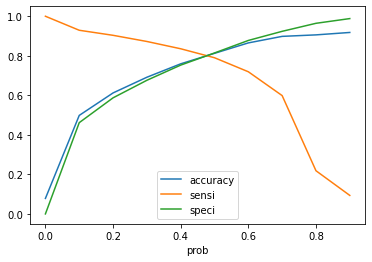

In [510]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

<b><font color='red'>[Observation]:</b> 
    <b>Logistic regression output - </b><br>
    <b> Accuracy 0.812375 </b><br>
    <b> Sensitivity 0.790071 </b><br>
    <b> Specificity 0.814274 </b><br>    

In [511]:
Logistic = [['0.812375','0.790071','0.814274']]
display(pd.DataFrame(data=Logistic,columns=['Accuracy','Sensitivity/Recall','Specificity']).style.hide_index())

Accuracy,Sensitivity/Recall,Specificity
0.812375,0.790071,0.814274


### Dimensionality reduction - let's use pca for dimention reductionality

### PCA 

In [512]:
from sklearn.decomposition import PCA
pca = PCA(random_state=42)
pca.fit(X_train)

PCA(random_state=42)

In [513]:
pca.components_

array([[ 1.62142383e-01,  1.70587897e-01,  1.39816624e-01, ...,
        -9.15736601e-05,  6.12064291e-03,  9.70505829e-06],
       [ 3.26373595e-02,  6.90838396e-02,  1.17168382e-01, ...,
        -9.28901359e-03,  1.02383425e-02,  3.93770285e-04],
       [ 9.33398535e-02,  1.40135790e-01,  1.43657879e-01, ...,
         1.13108637e-02,  5.57670283e-04, -2.11469766e-04],
       ...,
       [ 0.00000000e+00,  1.57756290e-16,  1.24221476e-16, ...,
         2.13068725e-17, -5.94169550e-17, -2.10553158e-16],
       [ 0.00000000e+00,  3.03000932e-16, -3.78674990e-16, ...,
        -6.90814270e-18,  4.67701808e-17,  1.71769299e-16],
       [-0.00000000e+00, -5.69530318e-17, -6.69330909e-17, ...,
        -3.72648729e-17,  1.12335378e-16, -3.84988087e-16]])

In [514]:
pca.explained_variance_ratio_

array([1.10897722e-01, 8.42016759e-02, 5.81908995e-02, 5.29757391e-02,
       3.94417170e-02, 3.87185967e-02, 3.76927656e-02, 3.33498991e-02,
       3.25363709e-02, 2.57765064e-02, 2.11097248e-02, 1.91169170e-02,
       1.78672867e-02, 1.72437752e-02, 1.60178168e-02, 1.54021129e-02,
       1.51522701e-02, 1.40003756e-02, 1.36751236e-02, 1.30259906e-02,
       1.29340238e-02, 1.25868676e-02, 1.19384374e-02, 1.10170183e-02,
       9.64198722e-03, 9.42302976e-03, 8.98931046e-03, 8.84329991e-03,
       8.61586993e-03, 8.40245347e-03, 8.14377286e-03, 7.78214083e-03,
       7.67150752e-03, 7.26991319e-03, 6.87915116e-03, 6.80327329e-03,
       6.37376558e-03, 6.27798853e-03, 6.19543245e-03, 6.05086521e-03,
       5.87043471e-03, 5.38987626e-03, 5.20923895e-03, 5.12544582e-03,
       5.00779200e-03, 4.62345268e-03, 4.42936138e-03, 4.21942093e-03,
       4.10671043e-03, 3.83362801e-03, 3.82577132e-03, 3.59108982e-03,
       3.42145957e-03, 3.39347089e-03, 3.36145606e-03, 3.22332633e-03,
      

In [515]:
var_cumu = np.cumsum(pca.explained_variance_ratio_)

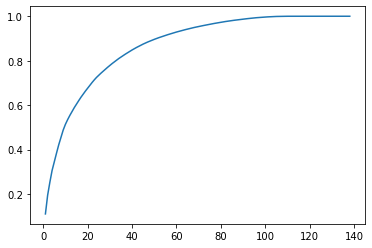

In [516]:
plt.plot(range(1,len(var_cumu)+1), var_cumu)

<b><font color='red'>[Observation]:</b> 60 features are explaining 90% variation in target variable

In [517]:
pc2 = PCA(n_components=60, random_state=42)

In [518]:
X_train_pca = pc2.fit_transform(X_train)

In [519]:
X_test_pca = pc2.transform(X_test)

In [520]:
X_train_pca.shape

(38478, 60)

### PCA with Logistic Regression

In [521]:
lr = LogisticRegression()
model = lr.fit(X_train_pca ,y_train)
#Making prediction on the test data
pred_probs_test = model.predict_proba(X_test_pca )[:,1]
print("Logistic regression accuracy".format(metrics.roc_auc_score(y_test, pred_probs_test)))
y_pred = lr.predict(X_test_pca )
model_attr(y_test,y_pred)

Logistic regression accuracy
[[6740 1541]
 [ 109  596]]


,Accuracy,Recall,AUC,F1
0,0.82,0.85,0.83,0.42


In [522]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
y_train_pred_final = pd.DataFrame([])
for i in numbers:
    y_train_pred_final[i]= pd.Series(y_pred_proba).map(lambda x: 1 if x > i else 0)
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_test, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.078455  1.000000  0.000000
0.1   0.1  0.498331  0.929078  0.461659
0.2   0.2  0.612063  0.903546  0.587248
0.3   0.3  0.691409  0.872340  0.676005
0.4   0.4  0.759292  0.835461  0.752808
0.5   0.5  0.812375  0.790071  0.814274
0.6   0.6  0.865124  0.719149  0.877551
0.7   0.7  0.898175  0.598582  0.923681
0.8   0.8  0.905742  0.218440  0.964256
0.9   0.9  0.917984  0.093617  0.988166


### 3) Random forest classifier (default)
we will use PCA for non interpretable models.

In [523]:
#for non interpretable models we will use X_train_pca to achieve highest performance
rfc = RandomForestClassifier()
rfc.fit(X_train_pca,y_train)

RandomForestClassifier()

In [524]:
y_pred = rfc.predict(X_test_pca)

In [525]:
confusion = metrics.confusion_matrix(y_test, y_pred )
print(confusion)

[[7827  454]
 [ 338  367]]


In [526]:
model_attr(y_test, y_pred)

[[7827  454]
 [ 338  367]]


,Accuracy,Recall,AUC,F1
0,0.91,0.52,0.73,0.48


In [527]:
#utility for tunning random forest
def random_tunning(parameters,X_train,y_train,n_folds = 5,max_depth=0):
    

    rf = RandomForestClassifier(max_depth=max_depth)
    
    rf = GridSearchCV(rf, parameters, cv=n_folds,n_jobs = -1, scoring="accuracy",return_train_score=True)
    rf.fit(X_train, y_train)
    scores = rf.cv_results_

    for key in parameters.keys():
        hyperparameters = key
        break

    # plotting accuracies for parameters
    plt.figure(figsize=(16,5))
    plt.plot(scores["param_"+hyperparameters], scores["mean_train_score"], label="Train_precision")
    plt.plot(scores["param_"+hyperparameters], scores["mean_test_score"], label="Test_precision")
    plt.xlabel(hyperparameters)
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

In [ ]:
# parameters to build the model on
parameters = {'max_depth': range(2, 30, 10)}
random_tunning(parameters,X_train_pca,y_train)

<b><font color='red'>[Observation]:</b> For max depth 15 we can obtain max precision.

In [ ]:
# parameters to build the model on
parameters = {'n_estimators': range(100, 300, 100)}
random_tunning(parameters,X_train_pca,y_train,5,16)

<b><font color='red'>[Observation]:</b> We can see that accuracy is maintaing across all values.

In [ ]:
# parameters to build the model on
parameters = {'max_features': [50,60]}
random_tunning(parameters,X_train_pca,y_train,5,16)

<b><font color='red'>[Observation]:</b> 

In [ ]:
# parameters to build the model on
parameters = {'min_samples_leaf': range(1, 50, 10)}
random_tunning(parameters,X_train_pca,y_train,5,16)

<b><font color='red'>[Observation]:</b> For max depth 15 we can obtain max precision.

In [ ]:
# parameters to build the model on
parameters = {'min_samples_split': range(10, 50, 10)}
random_tunning(parameters,X_train_pca,y_train,5,16)

<b><font color='red'>[Observation]:</b> For max depth 15 we can obtain max precision.

4) Random forest classifier (tuned)

In [ ]:
rfc = RandomForestClassifier(max_depth=16,
                             max_features=50,
                             min_samples_leaf=10,
                             min_samples_split=20,
                             n_estimators=200,
                             n_jobs = -1)
rfc.fit(X_train_pca,y_train)

In [ ]:
y_pred = rfc.predict(X_test_pca)
model_attr(y_test, y_pred)

### 5) XGBoosting (Default)

In [ ]:
### XGBoosting
model = XGBClassifier()
model.fit(X_train_pca, y_train)

In [ ]:
y_pred = model.predict(X_test_pca)
model_attr(y_test, y_pred)

 6) XGBoosting (tuned)

In [ ]:
folds = 5

# specify range of hyperparameters
param_grid = {'learning_rate': [0.1,0.2,0.3], 
             'subsample': [0.3,0.4,0.5]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'accuracy', # accuracy
                        cv = folds, 
                        n_jobs = -1,
                        verbose = 1,
                        return_train_score=True)   

In [ ]:
model_cv.fit(X_train_pca, y_train) 

In [ ]:
print('Best scores for model are'+str(round(model_cv.best_score_,2))+'** using '+str(model_cv.best_params_))

In [ ]:
params = {'learning_rate': 0.3,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.5,
         'objective':'binary:logistic'}

# fit model on training data
model = XGBClassifier(params = params,max_depth=2, n_estimators=200)
model.fit(X_train_pca, y_train)

In [ ]:
# predict
y_pred = model.predict(X_test_pca)

In [ ]:
#model parameters XGBoosting
model_attr(y_test,y_pred)

 7) Support Vector Machine (Default)

In [ ]:
#Let's go with default parameters
svc = SVC(C=1)


svc.fit(X_train_pca, y_train)

# predict
y_pred = svc.predict(X_test_pca)

In [ ]:
model_attr(y_test, y_pred)

 7) Support Vector Machine (tuned)

In [ ]:
# specify range of parameters (C) as a list
params = {"C": [0.1, 1, 5,10,15]}

model = SVC()

# set up grid search scheme
# note that we are still using the 5 fold CV scheme we set up earlier
model_cv = GridSearchCV(estimator = model, param_grid = params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                       return_train_score=True)   

In [ ]:
model_cv.fit(X_train_pca, y_train)  

In [ ]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

In [ ]:
# plot of C versus train and test scores

plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [ ]:
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test accuracy is {0} at C = {1}".format(best_score, best_C))

In [ ]:
model = SVC(C=best_C)

# fit
model.fit(X_train_pca, y_train)

# predict
y_pred = model.predict(X_test_pca)
model_attr(y_test,y_pred)

In [ ]:
#After analysing all the models we can see following results


## Results :-
<ul>
    <li>Customers who've spent around 6-24 Month on the network have the highest probablity of churn.</li>
    <li>Average revenue earned per customers drops in 8th Month (Action phase). Which is sign of possible churn</li>
    <li>Amount of data used and amount of data rechage for 8th month drops as compared to 6 and 7 th, which is an indication of possible churn.
</ul>